In [1]:
import os
os.chdir('../..')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.linear_model import LinearRegression
from collections import Iterable
import random
from os import listdir
from os.path import isfile, join

import scipy.stats as st

import seaborn as sns
sns.set_style("whitegrid")

# For the Python notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

D:\Users\glede\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  


# Calculations for stats and plots are based on: https://github.com/stasmix/popsynth/blob/master/pop-synth-vae.ipynb

# Load the files

In [3]:
dataset = 'LPMC'

In [4]:
synth_dir = '../synth_data/' + dataset

files = ['../data/' + dataset + '/data.csv']
labels = ['original']

for f in listdir(synth_dir):
    if isfile(join(synth_dir, f)):
        files.append(join(synth_dir, f))
        labels.append(f.split('.')[0])

In [5]:
labels

['original', 'CTGAN', 'DATGAN', 'TGAN']

In [6]:
dfs = [pd.read_csv(file) for file in files]

In [7]:
if dataset is 'Chicago':
    continuous_cols = ['distance', 'age', 'departure_time']
elif dataset is 'LPMC':
    continuous_cols = ['start_time_linear', 'age', 'distance', 'dur_walking', 'dur_cycling', 'dur_pt_access', 'dur_pt_rail', 'dur_pt_bus', 'dur_pt_int', 'dur_driving', 'cost_transit', 'cost_driving_fuel', 'driving_traffic_percent']

In [8]:
dfs[0]

,travel_mode,purpose,fueltype,faretype,bus_scale,survey_year,travel_year,travel_month,travel_date,day_of_week,...,dur_pt_access,dur_pt_rail,dur_pt_bus,dur_pt_int,pt_n_interchanges,dur_driving,cost_transit,cost_driving_fuel,cost_driving_con_charge,driving_traffic_percent
0,drive,HBO,Petrol_Car,full,1.0,1,2012,4,1,7,...,0.134444,0.000000,0.016667,0.000000,0,0.052222,1.5,0.14,0.0,0.111702
1,drive,HBO,Petrol_Car,full,1.0,1,2012,4,1,7,...,0.109444,0.000000,0.055556,0.000000,0,0.059444,1.5,0.15,0.0,0.112150
2,drive,HBO,Petrol_Car,full,1.0,1,2012,4,1,7,...,0.203056,0.000000,0.210278,0.000000,0,0.236667,1.5,0.79,0.0,0.203052
3,drive,HBO,Petrol_Car,full,1.0,1,2012,4,1,7,...,0.205556,0.000000,0.258611,0.000000,0,0.233333,1.5,0.78,0.0,0.160714
4,drive,HBO,Petrol_Car,dis,1.0,1,2012,4,1,7,...,0.203056,0.000000,0.189444,0.000000,0,0.229167,1.5,0.78,0.0,0.130909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81081,drive,HBO,Average_Car,full,1.0,3,2015,3,31,2,...,0.129722,0.466667,0.203333,0.216667,2,0.859722,4.3,2.48,0.0,0.402262
81082,drive,NHBO,Average_Car,full,1.0,3,2015,3,31,2,...,0.047500,0.466667,0.083333,0.183333,2,0.925833,4.3,2.53,0.0,0.503750
81083,drive,HBO,Average_Car,full,1.0,3,2015,3,31,2,...,0.118611,0.000000,0.166667,0.000000,0,0.112500,1.5,0.32,0.0,0.234568
81084,pt,HBW,Average_Car,full,1.0,3,2015,3,31,2,...,0.215833,0.283333,0.186667,0.250000,2,1.121944,4.4,2.38,10.5,0.760832


# Transform all values in numerical

In [9]:
dfs[0].dtypes

travel_mode                 object
purpose                     object
fueltype                    object
faretype                    object
bus_scale                  float64
survey_year                  int64
travel_year                  int64
travel_month                 int64
travel_date                  int64
day_of_week                  int64
start_time_linear          float64
age                          int64
female                       int64
driving_license              int64
car_ownership                int64
distance                     int64
dur_walking                float64
dur_cycling                float64
dur_pt_access              float64
dur_pt_rail                float64
dur_pt_bus                 float64
dur_pt_int                 float64
pt_n_interchanges            int64
dur_driving                float64
cost_transit               float64
cost_driving_fuel          float64
cost_driving_con_charge    float64
driving_traffic_percent    float64
dtype: object

In [10]:
if dataset is 'Chicago':
    ints = ['travel_dow', 'hh_vehicles', 'hh_size', 'hh_bikes', 'hh_descr', 'hh_income', 'gender', 'education_level', 'age']
    floats = ['departure_time', 'distance', 'license']
    strs = ['choice', 'trip_purpose', 'work_status']
elif dataset is 'LPMC':
    ints = ['survey_year', 'travel_year', 'travel_month', 'travel_date', 'day_of_week', 'age', 'female', 'driving_license', 'car_ownership', 'distance', 'pt_n_interchanges']
    floats = ['bus_scale', 'start_time_linear', 'dur_walking', 'dur_cycling', 'dur_pt_access', 'dur_pt_rail', 'dur_pt_bus', 'dur_pt_int', 'dur_driving', 'cost_transit', 'cost_driving_fuel', 'cost_driving_con_charge', 'driving_traffic_percent']
    strs = ['travel_mode', 'purpose', 'fueltype', 'faretype']

In [11]:
dct = {}

for i in ints:
    dct[i] = 'int64'
    
for i in floats:
    dct[i] = 'float64'

In [12]:
dfs = [df.astype(dct) for df in dfs]

In [13]:
for c in strs: 
    dct = {}
    
    for n, i in enumerate(dfs[0][c].unique()):        
        dct[i] = n
        
    dfs = [df.replace(dct) for df in dfs]

In [14]:
dfs[0].dtypes

travel_mode                  int64
purpose                      int64
fueltype                     int64
faretype                     int64
bus_scale                  float64
survey_year                  int64
travel_year                  int64
travel_month                 int64
travel_date                  int64
day_of_week                  int64
start_time_linear          float64
age                          int64
female                       int64
driving_license              int64
car_ownership                int64
distance                     int64
dur_walking                float64
dur_cycling                float64
dur_pt_access              float64
dur_pt_rail                float64
dur_pt_bus                 float64
dur_pt_int                 float64
pt_n_interchanges            int64
dur_driving                float64
cost_transit               float64
cost_driving_fuel          float64
cost_driving_con_charge    float64
driving_traffic_percent    float64
dtype: object

# Compute the stats

In [15]:
# calculate min_max_bins for an arbitrary discretization scheme
def get_min_max(data1, data2, num_bins, cont_cols):
    """
    Create a dictionnary with all variables indicating the number of bins and the min and max value 
    """
    
    min_max = {}
    eps = 1e-10
    
    # Go through all columns in the first dataset (assuming data2 has the same columns)
    for c in data1.columns:
        if c in cont_cols: # Continuous column
            
            # Compute min and max values between both datasets
            min_val = min(np.min(data1[c]), np.min(data2[c])) - eps
            max_val = max(np.max(data1[c]), np.max(data2[c])) + eps
            
            # Fill the dict
            min_max[c] = [min_val, max_val, num_bins]
            
        else: # Categorical column
            # Set of all unique values in both datasets
            unique_vals = set(np.unique(data1[c])).union(set(np.unique(data2[c])))
                                    
            num_bins_cat = min(len(unique_vals), num_bins)
            
            min_max[c] = [min(unique_vals), max(unique_vals), num_bins_cat]
                

    return min_max

In [16]:
def get_frequency_list(original, synthetic, max_num_bins, cat=True):
    """
    Compute the frequency lists
    """
    
    # Check if the number of unique values is less than the max
    # number of bins for the cat variables
    if cat:
        unique_vals = set(np.unique(original)).union(set(np.unique(synthetic)))
        
        if len(unique_vals) > max_num_bins:
            cat = False
    
    eps = 1e-10
    # Compute min and max values between both datasets
    min_val = min(np.min(original), np.min(synthetic)) - eps
    max_val = max(np.max(original), np.max(synthetic)) + eps
    
    # Compute the bins
    bins = []
    if cat:
        # bins = all values
        bins = list(unique_vals)
        bins.sort()
    else:
        # bins = hist bins
        delta = (max_val-min_val)/max_num_bins
        for i in range(max_num_bins+1):
            bins.append(min_val+delta*i)
            
    # Calculate the frequencies
    freqs = []
    if cat:
        count_orig = [(original==b).sum() for b in bins]
        count_synth = [(synthetic==b).sum() for b in bins]
        
        freqs = [count_orig, count_synth]
    else:
        hist_orig, _ = np.histogram(original, bins)
        hist_synth, _ = np.histogram(synthetic, bins)
        
        freqs = [hist_orig, hist_synth]

            
    return freqs, bins

In [17]:
def stats(freq_list_orig, freq_list_synth):
    """
    Different statistics computed on the frequency list
    
    """
    freq_list_orig, freq_list_synth = np.array(freq_list_orig), np.array(freq_list_synth)
    corr_mat = np.corrcoef(freq_list_orig, freq_list_synth)
    corr = corr_mat[0, 1]
    if np.isnan(corr): corr = 0.0
    # MAE
    mae = np.absolute(freq_list_orig - freq_list_synth).mean()
    # RMSE
    rmse = np.linalg.norm(freq_list_orig - freq_list_synth) / np.sqrt(len(freq_list_orig))
    # SRMSE
    freq_list_orig_avg = freq_list_orig.mean()
    srmse = rmse / freq_list_orig_avg
    # r-square
    u = np.sum((freq_list_synth - freq_list_orig)**2)
    v = np.sum((freq_list_orig - freq_list_orig_avg)**2)
    r2 = 1.0 - u / v
    stat = {'mae': mae, 'rmse': rmse, 'r2': r2, 'srmse': srmse, 'corr': corr}
    
    return stat

In [18]:
def plot(freqs_original, freqs_synthetic, title=None, filename=None):
    f = plt.figure(figsize=(10,10))
    
    font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

    matplotlib.rc('font', **font)
    ax = f.add_subplot(111)
    
    min_val = min(np.min(freqs_original), np.min(freqs_synthetic))
    max_val = max(np.max(freqs_original), np.max(freqs_synthetic))
    
    plt.plot(freqs_original, freqs_synthetic, 'ok')
    
    reg = LinearRegression()
    reg.fit(np.array(freqs_original)[:, np.newaxis], np.array(freqs_synthetic))
    
    xfit = np.linspace(np.min(freqs_original), np.max(freqs_original), 10)
    yfit = reg.predict(xfit[:, np.newaxis])
    
    plt.plot(xfit, yfit, 'grey')
    
    stat = stats(freqs_original, freqs_synthetic)
    
    str_ = "SRMSE={:.3f}\nR²={:.3f}\ny={:.3f}x".format(stat['srmse'], stat['r2'], reg.coef_[0])
    
    t = plt.text(0.05, 0.9,str_,
                 horizontalalignment='left',
                 verticalalignment='center',
                 transform = ax.transAxes,
                 fontsize=18)
    
    t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='black'))
    
    plt.xlabel('Observed frequencies')
    plt.ylabel('Simulated frequencies')
    plt.xlim((0,8000))
    plt.ylim((0,8000))
    
    if title is not None:
        plt.title(title)
        
    if filename is not None:
        plt.savefig(filename + '.png', bbox_inches='tight')
        plt.savefig(filename + '.pdf', bbox_inches='tight')

# Let's have some fun =)

In [19]:
orig_freqs = []
synth_freqs = []

for i in range(len(dfs)-1):
    synth_freqs.append([])

for c in dfs[0].columns:
    for i in range(1, len(dfs)):
        
        [a,b],bins = get_frequency_list(dfs[0][c], dfs[i][c], 50, c not in continuous_cols)
        
        if i == 1:
            orig_freqs.append(a)
        
        synth_freqs[i-1].append(b)

In [20]:
def flatten(items):
    """Yield items from any nested iterable; see Reference."""
    for x in items:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            for sub_x in flatten(x):
                yield sub_x
        else:
            yield x

In [21]:
orig_freqs = list(flatten(orig_freqs))


for i in range(len(synth_freqs)):
    synth_freqs[i] = list(flatten(synth_freqs[i]))

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


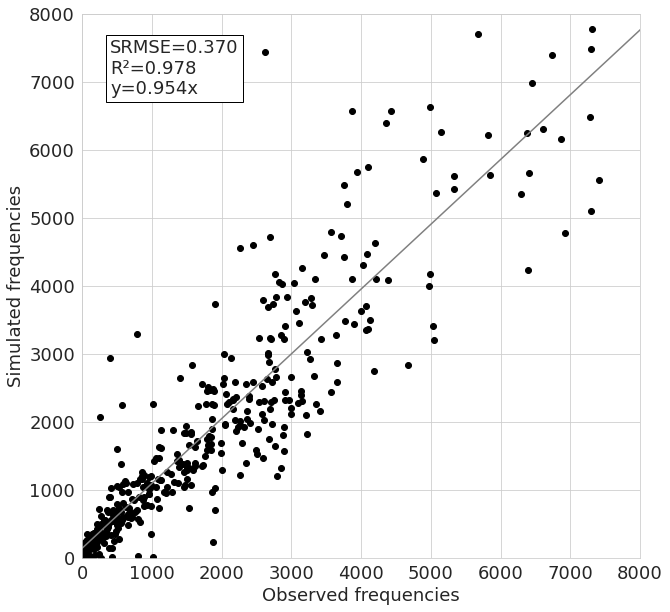

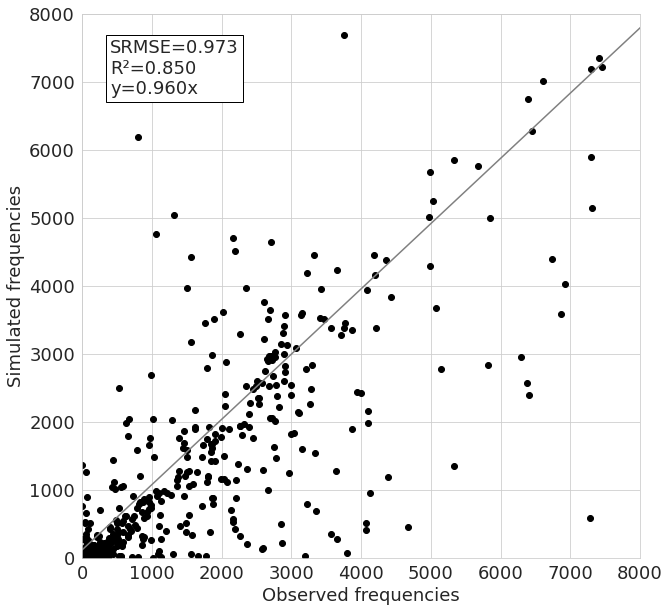

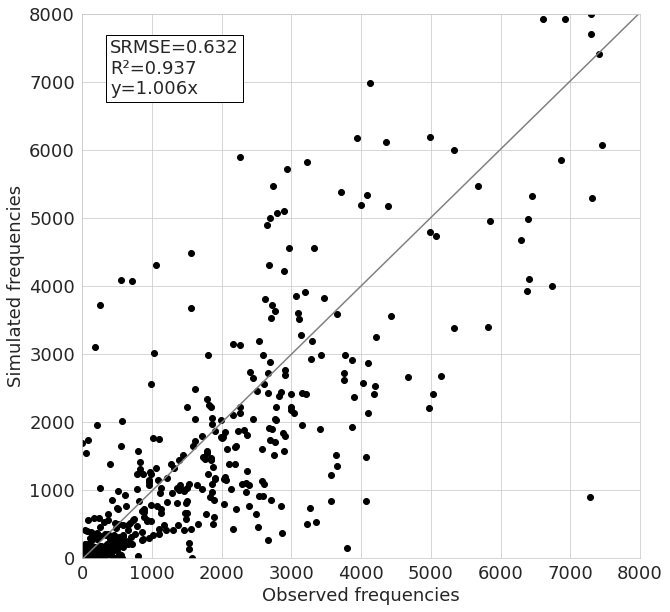

In [22]:
for i in range(len(synth_freqs)):  
    #plot(orig_freqs, synth_freqs[i], labels[0] + ' - ' + labels[i+1])
    plot(orig_freqs, synth_freqs[i], None, '../figures/' + dataset + '/' + labels[i+1])

# Stats by model

In [23]:
stats_vals = []

for i in range(len(dfs)-1):
    stats_vals.append({'mae': [], 'rmse': [], 'r2': [], 'srmse': [], 'corr': []})

for c in dfs[0].columns:
    for i in range(1, len(dfs)):
        
        [a,b],bins = get_frequency_list(dfs[0][c], dfs[i][c], 50)
        
        stat = stats(a,b)
        
        for k in stat.keys():
            stats_vals[i-1][k].append(stat[k])
            
n = len(stats_vals)

In [24]:
print("Weighted average of SRMSE")
for i in range(n):
    print("{}: {:.3f} +- {:.3f}".format(labels[i+1], np.mean(stats_vals[i]['srmse']), np.std(stats_vals[i]['srmse'])))

Weighted average of SRMSE
CTGAN: 0.267 +- 0.149
DATGAN: 0.520 +- 0.660
TGAN: 0.479 +- 0.577


In [25]:
print("Weighted average of RMSE")
for i in range(n):
    print("{}: {:.3f} +- {:.3f}".format(labels[i+1], np.mean(stats_vals[i]['rmse']), np.std(stats_vals[i]['rmse'])))

Weighted average of RMSE
CTGAN: 1889.071 +- 1886.681
DATGAN: 1184.368 +- 936.730
TGAN: 1280.164 +- 802.060


In [26]:
print("Weighted average of MAE")
for i in range(n):
    print("{}: {:.3f} +- {:.3f}".format(labels[i+1], np.mean(stats_vals[i]['mae']), np.std(stats_vals[i]['mae'])))

Weighted average of MAE
CTGAN: 1561.135 +- 1840.307
DATGAN: 674.806 +- 482.744
TGAN: 804.784 +- 518.845


In [27]:
print("Weighted average of R^2")
for i in range(n):
    print("{}: {:.3f} +- {:.3f}".format(labels[i+1], np.mean(stats_vals[i]['r2']), np.std(stats_vals[i]['r2'])))

Weighted average of R^2
CTGAN: -0.540 +- 4.089
DATGAN: 0.526 +- 0.967
TGAN: -0.401 +- 4.694


In [28]:
print("Weighted average of corr")
for i in range(n):
    print("{}: {:.3f} +- {:.3f}".format(labels[i+1], np.mean(stats_vals[i]['corr']), np.std(stats_vals[i]['corr'])))

Weighted average of corr
CTGAN: 0.835 +- 0.369
DATGAN: 0.859 +- 0.251
TGAN: 0.827 +- 0.382


# Continuous vs Categorical

In [32]:
msk = []
for i in dfs[0].columns:
    if i in continuous_cols:
        msk.append(True)
    else:
        msk.append(False)
msk = np.array(msk)

In [38]:
print("Weighted average of SRMSE (continuous / categorical)")
for i in range(n):
    print("{}: {:.3f} +- {:.3f} / {:.3f} +- {:.3f}".format(labels[i+1], np.mean(np.array(stats_vals[i]['srmse'])[msk]), 
                                                           np.std(np.array(stats_vals[i]['srmse'])[msk]),
                                                           np.mean(np.array(stats_vals[i]['srmse'])[~msk]), 
                                                           np.std(np.array(stats_vals[i]['srmse'])[~msk])))

Weighted average of SRMSE (continuous / categorical)
CTGAN: 0.372 +- 0.106 / 0.176 +- 0.117
DATGAN: 1.068 +- 0.613 / 0.045 +- 0.035
TGAN: 0.927 +- 0.566 / 0.090 +- 0.131


In [39]:
print("Weighted average of RMSE (continuous / categorical)")
for i in range(n):
    print("{}: {:.3f} +- {:.3f} / {:.3f} +- {:.3f}".format(labels[i+1], np.mean(np.array(stats_vals[i]['rmse'])[msk]), 
                                                           np.std(np.array(stats_vals[i]['rmse'])[msk]),
                                                           np.mean(np.array(stats_vals[i]['rmse'])[~msk]), 
                                                           np.std(np.array(stats_vals[i]['rmse'])[~msk])))

Weighted average of RMSE (continuous / categorical)
CTGAN: 602.513 +- 171.888 / 3004.089 +- 1985.225
DATGAN: 1731.990 +- 993.672 / 709.762 +- 545.017
TGAN: 1503.707 +- 918.336 / 1086.427 +- 623.771


In [40]:
print("Weighted average of MAE (continuous / categorical)")
for i in range(n):
    print("{}: {:.3f} +- {:.3f} / {:.3f} +- {:.3f}".format(labels[i+1], np.mean(np.array(stats_vals[i]['mae'])[msk]), 
                                                           np.std(np.array(stats_vals[i]['mae'])[msk]),
                                                           np.mean(np.array(stats_vals[i]['mae'])[~msk]), 
                                                           np.std(np.array(stats_vals[i]['mae'])[~msk])))

Weighted average of MAE (continuous / categorical)
CTGAN: 309.954 +- 80.598 / 2645.493 +- 1945.176
DATGAN: 719.452 +- 438.831 / 636.112 +- 514.675
TGAN: 635.831 +- 373.725 / 951.210 +- 579.033


In [41]:
print("Weighted average of R^2 (continuous / categorical)")
for i in range(n):
    print("{}: {:.3f} +- {:.3f} / {:.3f} +- {:.3f}".format(labels[i+1], np.mean(np.array(stats_vals[i]['r2'])[msk]), 
                                                           np.std(np.array(stats_vals[i]['r2'])[msk]),
                                                           np.mean(np.array(stats_vals[i]['r2'])[~msk]), 
                                                           np.std(np.array(stats_vals[i]['r2'])[~msk])))

Weighted average of R^2 (continuous / categorical)
CTGAN: 0.935 +- 0.081 / -1.818 +- 5.262
DATGAN: 0.237 +- 1.296 / 0.776 +- 0.394
TGAN: 0.379 +- 0.904 / -1.076 +- 6.279


In [42]:
print("Weighted average of Pearson's corr (continuous / categorical)")
for i in range(n):
    print("{}: {:.3f} +- {:.3f} / {:.3f} +- {:.3f}".format(labels[i+1], np.mean(np.array(stats_vals[i]['corr'])[msk]), 
                                                           np.std(np.array(stats_vals[i]['corr'])[msk]),
                                                           np.mean(np.array(stats_vals[i]['corr'])[~msk]), 
                                                           np.std(np.array(stats_vals[i]['corr'])[~msk])))

Weighted average of Pearson's corr (continuous / categorical)
CTGAN: 0.971 +- 0.037 / 0.718 +- 0.472
DATGAN: 0.822 +- 0.176 / 0.891 +- 0.297
TGAN: 0.838 +- 0.188 / 0.817 +- 0.491
